In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2 as cv
import torchlayers as tl
import os

In [8]:
import sys
import platform

print("ARCH:", platform.architecture())
print(torch.__version__)
print(torch.cuda.is_available())
torch.zeros(1).cuda()

ARCH: ('64bit', 'WindowsPE')
1.8.1
True


tensor([0.], device='cuda:0')

5141 4112 1029
Ssangyong


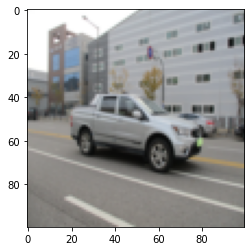

In [72]:
trans = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
datas = torchvision.datasets.ImageFolder(root = "./data/kcar", transform = trans)
labels = datas.classes

train_size = int(len(datas) * 0.8)
test_size = len(datas) - train_size
train_data, test_data = torch.utils.data.random_split(datas, [train_size, test_size])
img, label = test_data[0]
print(len(datas), len(train_data), len(test_data))
print(labels[label])
imshow(img)

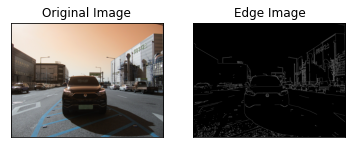

True .jpg .\data\kcar_edge\Ssangyong\쌍용_G4렉스턴_2017_10시대_H0_V0_edge.jpg [[255]
 [216]
 [255]
 ...
 [ 21]
 [255]
 [217]]


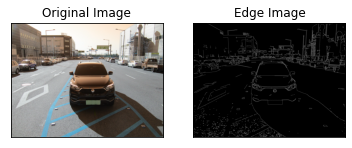

True .jpg .\data\kcar_edge\Ssangyong\쌍용_G4렉스턴_2017_10시대_H0_V15_edge.jpg [[255]
 [216]
 [255]
 ...
 [138]
 [255]
 [217]]


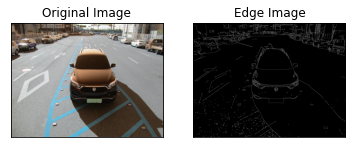

True .jpg .\data\kcar_edge\Ssangyong\쌍용_G4렉스턴_2017_10시대_H0_V30_edge.jpg [[255]
 [216]
 [255]
 ...
 [ 21]
 [255]
 [217]]


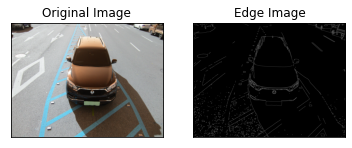

True .jpg .\data\kcar_edge\Ssangyong\쌍용_G4렉스턴_2017_10시대_H0_V45_edge.jpg [[255]
 [216]
 [255]
 ...
 [127]
 [255]
 [217]]


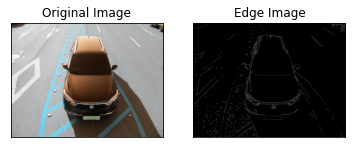

True .jpg .\data\kcar_edge\Ssangyong\쌍용_G4렉스턴_2017_10시대_H0_V60_edge.jpg [[255]
 [216]
 [255]
 ...
 [ 43]
 [255]
 [217]]


In [152]:
edges=[]
name = ["0", "15", "30", "45", "60"]
for n in name:
    # p = ".\\data\\kcar\\GM Daewoo\\GM Daewoo\\GM Daewoo\\GM Daewoo\\알페온\\2011\\10시대\\H0\\GM대우_알페온_2011_10시대_H0_V"
    p = ".\\data\\kcar\\Ssangyong\\Ssangyong\\Ssangyong\\Ssangyong\\G4 렉스턴\\2017\\10시대\\H0\\쌍용_G4렉스턴_2017_10시대_H0_V"
    path = p+n+".jpg"
    img_array = np.fromfile(path, np.uint8)
    im = cv.imdecode(img_array, cv.IMREAD_COLOR)
    im = cv.GaussianBlur(im, (5, 5), 0)
    edges.append(cv.Canny(im,100,200))
    plt.subplot(121),plt.imshow(im,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(edges[-1],cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.show()

    new_name = ".\\data\\kcar_edge\\Ssangyong\\쌍용_G4렉스턴_2017_10시대_H0_V"+n+"_edge.jpg"
    extension = os.path.splitext(new_name)[1] # 이미지 확장자
    result, encoded_img = cv.imencode(extension, edges[-1])
    print(result, extension, new_name, encoded_img)
 
    if result:
        with open(new_name, mode='w+b') as f:
            encoded_img.tofile(f)



In [9]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def imshow(img):
    img = img /2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1,2,0)))
    # plt.show()


In [11]:
class CNN(tl.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = tl.Conv2d(64, kernel_size=6)
        self.conv2 = tl.Conv2d(128, kernel_size=3)
        self.conv3 = tl.Conv2d(256, kernel_size=3, padding=1)
        self.fc1 = tl.Linear(120)
        self.fc2 = tl.Linear(60)
        self.fc3 = tl.Linear(10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)

        x = x.view(-1, self.num_flat_features(x)) # [batch_size, 50, 4, 4]
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):  
        size = x.size()[1:] 
        num_features = 1 
        for s in size: 
            num_features *= s 
        return num_features


In [244]:
train_loader = DataLoader(train_data, batch_size = 5, shuffle = True, num_workers = 4)
test_loader = DataLoader(test_data, batch_size = 5)

In [265]:
model1 = torch.nn.Sequential(
    tl.Conv(64),  # specify ONLY out_channels
    torch.nn.ReLU(),  # use torch.nn wherever you wish
    tl.BatchNorm(),  # BatchNormNd inferred from input
    tl.Conv(128),  # Default kernel_size equal to 3
    tl.ReLU(),
    # tl.Conv(256, kernel_size=11),  # "same" padding as default
    tl.GlobalMaxPool(),  # Known from Keras
    # tl.Linear(2),  # Output for 2 classes
)
model1 = tl.build(model1, torch.randn(1, 3, 28, 28))
model1.cuda()
model2 = torch.nn.Sequential(
    tl.Conv(64),  # specify ONLY out_channels
    torch.nn.ReLU(),  # use torch.nn wherever you wish
    tl.BatchNorm(),  # BatchNormNd inferred from input
    tl.Conv(128),  # Default kernel_size equal to 3
    tl.ReLU(),
    tl.GlobalMaxPool(),  # Known from Keras
)
model2 = tl.build(model2, torch.randn(1, 3, 28, 28))
model2.cuda()

one_way_model = torch.nn.Sequential(
    tl.Conv(64),  # specify ONLY out_channels
    tl.ReLU(),  # use torch.nn wherever you wish
    tl.BatchNorm(),  # BatchNormNd inferred from input
    tl.Conv(128),  # Default kernel_size equal to 3
    tl.ReLU(),
    tl.Conv(256, kernel_size=11),  # "same" padding as default
    tl.GlobalMaxPool(),  # Known from Keras
    tl.Linear(2),  # Output for 2 classes
)
one_way_model = tl.build(one_way_model, torch.randn(1, 3, 28, 28))
one_way_model.cuda()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(128, 256, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (6): GlobalMaxPool()
  (7): Linear(in_features=256, out_features=2, bias=True)
)

In [243]:
vgg_model = torchvision.models.vgg16(pretrained=True)
# arbitrary
last_module = nn.Linear(100, 2, bias=True)
vgg_model.add_module('last_module', last_module)
# last_module.apply(user_defined_initialize_function)
vgg_model.cuda()
model = vgg_model

In [262]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.fc = nn.Linear(256, 2)
        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

model = MyEnsemble(model1, model2)
# model = tl.build(model, torch.randn(1, 3, 28, 28), torch.randn(1, 3, 28, 28))
model.cuda()

MyEnsemble(
  (modelA): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): GlobalMaxPool()
  )
  (modelB): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): GlobalMaxPool()
  )
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

In [258]:
# model = CNN()
# cnn = tl.build(model.cuda(), torch.randn(1, 3, 32, 32))
criterion = torch.nn.CrossEntropyLoss()

# set optimizer. model.parameter를 넘겨준다.
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.5, 0.999))
# optimizer = optim.SGD(model.parameters(), lr=0.01)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')
print(torch.cuda.is_available())
torch.cuda.empty_cache()

cuda:0 is available
True


In [260]:
model.train()  # 학습
for epoch in range(1):
  for index, (data, target) in enumerate(train_loader):
    final_out = []
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()  # 기울기 초기화

    output = model(data, data)
    final_out.extend(output.tolist())
    final_out = np.array(final_out)
    
    loss = criterion(output, target)
    loss.backward()  # 역전파
    optimizer.step()

    if index % 10 == 0:
      print("loss of {} epoch, {} index : {}".format(epoch, index, loss.item()))

torch.Size([5, 128]) torch.Size([5, 128]) torch.Size([5, 256])
loss of 0 epoch, 0 index : 0.7059555649757385
torch.Size([5, 128]) torch.Size([5, 128]) torch.Size([5, 256])
torch.Size([5, 128]) torch.Size([5, 128]) torch.Size([5, 256])
torch.Size([5, 128]) torch.Size([5, 128]) torch.Size([5, 256])
torch.Size([5, 128]) torch.Size([5, 128]) torch.Size([5, 256])
torch.Size([5, 128]) torch.Size([5, 128]) torch.Size([5, 256])
torch.Size([5, 128]) torch.Size([5, 128]) torch.Size([5, 256])
torch.Size([5, 128]) torch.Size([5, 128]) torch.Size([5, 256])
torch.Size([5, 128]) torch.Size([5, 128]) torch.Size([5, 256])
torch.Size([5, 128]) torch.Size([5, 128]) torch.Size([5, 256])
torch.Size([5, 128]) torch.Size([5, 128]) torch.Size([5, 256])
loss of 0 epoch, 10 index : 0.39611107110977173
torch.Size([5, 128]) torch.Size([5, 128]) torch.Size([5, 256])
torch.Size([5, 128]) torch.Size([5, 128]) torch.Size([5, 256])
torch.Size([5, 128]) torch.Size([5, 128]) torch.Size([5, 256])
torch.Size([5, 128]) tor

In [263]:
model.eval()  # test
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    output = model(data, data)
    test_loss += criterion(output, target).item() # sum up batch loss
    pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


Test set: Average loss: 235.4691, Accuracy: 778/1029 (76%)



In [268]:
#one_way_model
one_way_criterion = torch.nn.CrossEntropyLoss()
one_way_optimizer = optim.Adam(one_way_model.parameters(), lr=0.0001, betas=(0.5, 0.999))
one_way_model.train()  # 학습
for epoch in range(3):
  for index, (data, target) in enumerate(train_loader):
    final_out = []
    data, target = data.cuda(), target.cuda()
    one_way_optimizer.zero_grad()  # 기울기 초기화

    output = one_way_model(data)
    final_out.extend(output.tolist())
    final_out = np.array(final_out)
    
    loss = one_way_criterion(output, target)
    loss.backward()  # 역전파
    one_way_optimizer.step()

    if index % 10 == 0:
      print("loss of {} epoch, {} index : {}".format(epoch, index, loss.item()))

one_way_model.eval()  # test
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    output = one_way_model(data)
    test_loss += one_way_criterion(output, target).item() # sum up batch loss
    pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

loss of 0 epoch, 0 index : 0.50153648853302
loss of 0 epoch, 10 index : 0.2917637526988983
loss of 0 epoch, 20 index : 0.07887344062328339
loss of 0 epoch, 30 index : 1.077331781387329
loss of 0 epoch, 40 index : 0.24631083011627197
loss of 0 epoch, 50 index : 0.13244269788265228
loss of 0 epoch, 60 index : 0.4233438968658447
loss of 0 epoch, 70 index : 0.03785015270113945
loss of 0 epoch, 80 index : 0.46005257964134216
loss of 0 epoch, 90 index : 0.014871855266392231
loss of 0 epoch, 100 index : 0.8413206338882446
loss of 0 epoch, 110 index : 0.0246584415435791
loss of 0 epoch, 120 index : 0.2880571484565735
loss of 0 epoch, 130 index : 0.21598608791828156
loss of 0 epoch, 140 index : 0.2804989516735077
loss of 0 epoch, 150 index : 0.3895570933818817
loss of 0 epoch, 160 index : 0.20166167616844177
loss of 0 epoch, 170 index : 0.5460494160652161
loss of 0 epoch, 180 index : 0.34946465492248535
loss of 0 epoch, 190 index : 0.2544021010398865
loss of 0 epoch, 200 index : 0.0530357137322